<a href="https://colab.research.google.com/github/gedsmit/Acronym-Resolver/blob/main/01_Acronym_resolver_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get train data
!wget https://raw.githubusercontent.com/paudan/acronym-expansion/main/data/train.json
!wget "https://raw.githubusercontent.com/paudan/acronym-expansion/main/data/diction.json"


--2021-11-19 17:58:33--  https://raw.githubusercontent.com/paudan/acronym-expansion/main/data/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17354149 (17M) [text/plain]
Saving to: ‘train.json’

train.json          100%[===================>]  16.55M  94.7MB/s    in 0.2s    

2021-11-19 17:58:34 (94.7 MB/s) - ‘train.json’ saved [17354149/17354149]

--2021-11-19 17:58:34--  https://raw.githubusercontent.com/paudan/acronym-expansion/main/data/diction.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76910 (75K) [text/pl

In [ ]:
import pandas as pd
import json
train_data_full = pd.io.json.read_json("train.json")
with open('diction.json') as json_data:
    diction = json.load(json_data)

In [ ]:
train_data_full['count']=train_data_full.groupby('expansion')['expansion'].transform('count')
train_data_full.sort_values(by='count', axis = 0, ascending=False)

train_data_full['expansion'].value_counts()



convolutional neural network    2579
recurrent neural network        1064
forward error correction        1036
computed tomography              842
reinforcement learning           822
                                ... 
emergency department               1
single architecture                1
mask pyramid                       1
forward models                     1
barabasi albert                    1
Name: expansion, Length: 2150, dtype: int64

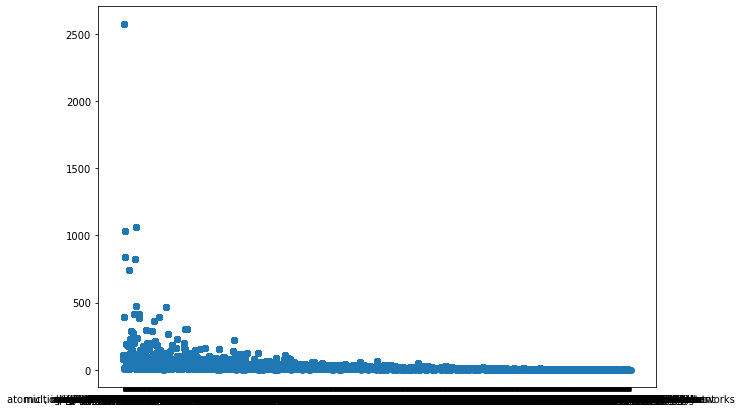

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(train_data_full['expansion'], train_data_full['count'], label="acronyms")
# plt.show

In [ ]:
train_data_full['count']=train_data_full.groupby('expansion')['expansion'].transform('count')
train_data_balanced = train_data_full.loc[(train_data_full['count'] >= 150) & (train_data_full['count'] <= 250)]

<function matplotlib.pyplot.show>

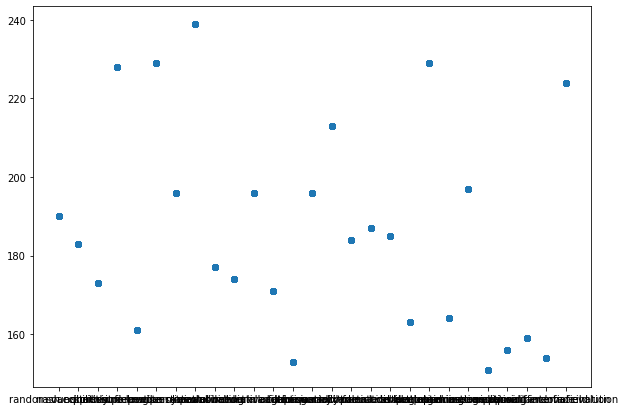

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(train_data_balanced['expansion'], train_data_balanced['count'], label="acronyms")
plt.show

In [ ]:
train_data_balanced = train_data_balanced.reset_index(drop=True) 

In [ ]:
train_data_balanced['acronym_value'] = None

for row in range(len(train_data_balanced)):
  train_data_balanced['acronym_value'][row] = \
      train_data_balanced['tokens'][row][int(train_data_balanced['acronym'][row])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
  # Create extend dataframe with all possible expansion values, add column 'label' with labels and add column 'sentences' with possible expansion forms 

  train_data_extended = pd.DataFrame(columns=['tokens','acronym','expansion','label'])
  train_data_extended['sentences'] = None

  for row in range(len(train_data_balanced)):
    expansions = diction[train_data_balanced['acronym_value'][row]]
    truth_expansion = train_data_balanced['expansion'][row]
    
    if not(train_data_balanced['acronym_value'][row] in diction.keys()) or not(truth_expansion in expansions):
      expansions = expansions.append(truth_expansion) 
      diction[train_data_balanced['acronym_value'][row]] = expansions
    
    for x in range(len(expansions)):
      train_data_extended = train_data_extended.append({'tokens': train_data_balanced['tokens'][row], 'acronym': train_data_balanced['acronym_value'][row], \
                  'expansion': expansions[x], 'label': None}, ignore_index=True)
      if(expansions[x].strip() == truth_expansion.strip()):
        train_data_extended['label'].iloc[-1] = 1
      else:
        train_data_extended['label'].iloc[-1] = 0
      
      train_data_extended['sentences'].iloc[-1]=" ".join(train_data_extended['tokens'].iloc[-1]).replace(train_data_extended['acronym'].iloc[-1], \
                                                                                                         train_data_extended['expansion'].iloc[-1])
  train_data_extended


,tokens,acronym,expansion,label,sentences
0,"[The, AV, and, RV, strategy, requires, informa...",RV,random vaccination,1,The AV and random vaccination strategy require...
1,"[The, AV, and, RV, strategy, requires, informa...",RV,right ventricle,0,The AV and right ventricle strategy requires i...
2,"[The, AV, and, RV, strategy, requires, informa...",RV,random voting,0,The AV and random voting strategy requires inf...
3,"[The, AV, and, RV, strategy, requires, informa...",RV,random variable,0,The AV and random variable strategy requires i...
4,"[The, AV, and, RV, strategy, requires, informa...",RV,resilience vector,0,The AV and resilience vector strategy requires...
...,...,...,...,...,...
20850,"[Akin, to, the, training, examples, required, ...",IR,incremental relaying,0,Akin to the training examples required for an ...
20851,"[Akin, to, the, training, examples, required, ...",IR,image resolution,0,Akin to the training examples required for an ...
20852,"[Akin, to, the, training, examples, required, ...",IR,inactive region,0,Akin to the training examples required for an ...
20853,"[Instead, of, directly, learning, the, log, -,...",NN,neural network,1,"Instead of directly learning the log - prior ,..."


In [ ]:
# set train and validation data
train_sentences = train_data_extended['sentences'][:17000]
train_labels = train_data_extended['label'][:17000].astype('float32')
val_sentences = train_data_extended['sentences'][17000:]
val_labels = train_data_extended['label'][17000:].astype('float32')

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf 
from tensorflow.keras import layers


In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [ ]:
# Create model using the Sequential API
model_1 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_1")

# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
SAVE_DIR = "MyModel1"

In [ ]:
train_sentences.shape

(17000,)

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

--2021-11-19 18:13:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-19 18:13:56 (63.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]

Saving TensorBoard log files to: MyModel1/tf_hub_sentence_encoder/20211119-181356
Epoch 1/5
532/532 [==============================] - 20s 28ms/step - loss: 0.4692 - accuracy: 0.7879 - val_loss: 0.3936 - val_accuracy: 0.8311
Epoch 2/5
532/532 [==============================] - 14s 27ms/step - loss: 0.3514 - accuracy: 0.8479 - val_loss: 0.3249 - val_accuracy: 0.8721
Epoch

In [ ]:
model_1.evaluate(val_sentences, val_labels)

121/121 [==============================] - 2s 18ms/step - loss: 0.2167 - accuracy: 0.9240


[0.21671181917190552, 0.9239948391914368]

In [ ]:
from helper_functions import calculate_results

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results


{'accuracy': 92.39948119325551,
 'f1': 0.9219514588151075,
 'precision': 0.9229123011753817,
 'recall': 0.9239948119325552}